In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
df_1 = pd.read_csv('winequality-red.csv', sep=';')
df_1['type_wine'] = 1
df_2 = pd.read_csv('winequality-white.csv', sep=';')
df_2['type_wine'] = 0
df = pd.concat([df_1, df_2])
new_columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'type_wine']
df.columns = new_columns
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


### Проверим распределение целевой пееменной type_wine

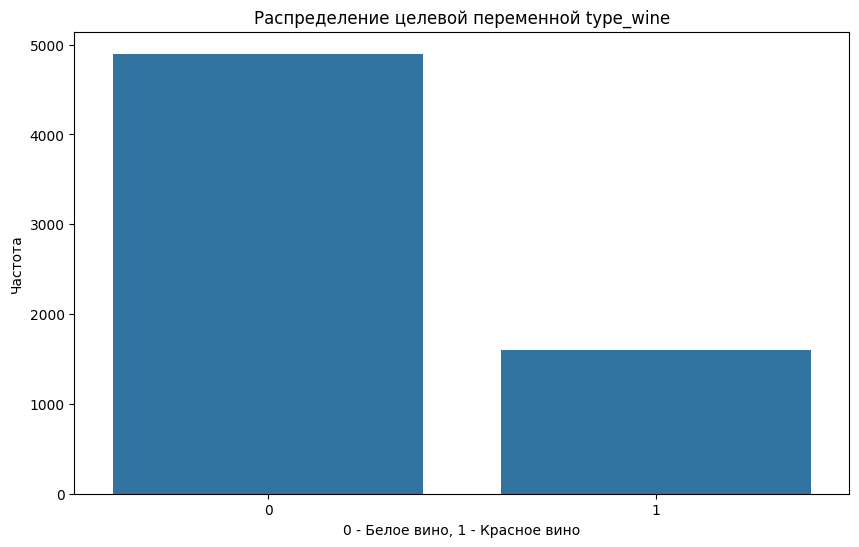

In [4]:
counts = df['type_wine'].value_counts()

plt.figure(figsize=(10, 6))

sns.barplot(data=counts)
plt.title('Распределение целевой переменной type_wine')
plt.xlabel('0 - Белое вино, 1 - Красное вино')
plt.ylabel('Частота')
plt.show()

Как я вижу, белое вино преобладает в нашем датафрейме, причем где-то в три раза

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type_wine             6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


Пропусков нет, типы данных соответствуют

In [6]:
from sklearn.model_selection import train_test_split

feauters = df.drop(['type_wine'], axis=1)
target = df['type_wine']

feauters_train, feauters_val, target_train, target_val = train_test_split(feauters, target, test_size=0.25, random_state=42)

print(f'Размер обучающий выборке: {feauters_train.shape}')
print(f'Размер валидационной выборке: {feauters_val.shape}')

Размер обучающий выборке: (4872, 12)
Размер валидационной выборке: (1625, 12)


In [7]:
def balanced_accuracy_score_my(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    unique_class = np.unique(y_true)
    num_unique_class = len(unique_class)

    recall_class = []

    for i in unique_class:

        tp = np.sum((y_true == i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) == 0:
            recall = 0.0
        else:
            recall = tp / (tp + fn)

        recall_class.append(recall)

    if num_unique_class == 0:
        balanced_accuracy = 0.0
    else:
        balanced_accuracy = np.mean(recall_class)

    return balanced_accuracy


In [8]:
from sklearn.metrics import balanced_accuracy_score

y_true = [0, 1, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 1, 0, 0, 1]

my_score = balanced_accuracy_score_my(y_true, y_pred)
sklearn_score = balanced_accuracy_score(y_true, y_pred)

print(f'Моё значение balanced_accuracy_score: {my_score}')
print(f'Библиотечное значение balanced_accuracy_score: {sklearn_score}')

Моё значение balanced_accuracy_score: 0.625
Библиотечное значение balanced_accuracy_score: 0.625


Text(0, 0.5, 'balanced_accuracy')

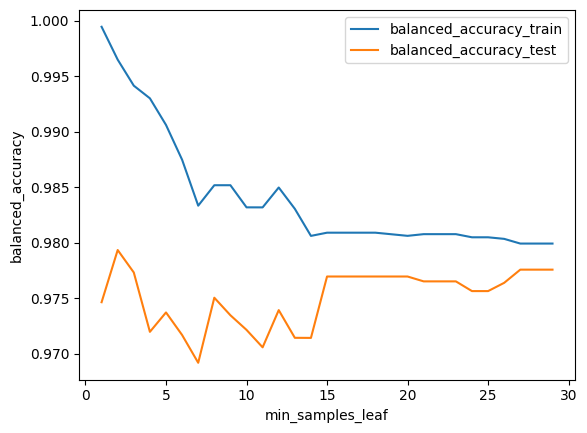

In [9]:
res = []
for param in range(1, 30, 1):
    model = DecisionTreeClassifier(min_samples_leaf=param, random_state=7)

    model.fit(feauters_train, target_train)
    pred_train = model.predict(feauters_train)
    pred_test = model.predict(feauters_val)

    res.append([param, balanced_accuracy_score(pred_train, target_train), balanced_accuracy_score(pred_test, target_val)])
    
res_pd = pd.DataFrame(res, columns=['min_samples_leaf', 'balanced_accuracy_train', 'balanced_accuracy_test'])

res_pd.set_index('min_samples_leaf')['balanced_accuracy_train'].plot(label='balanced_accuracy_train')
res_pd.set_index('min_samples_leaf')['balanced_accuracy_test'].plot(label='balanced_accuracy_test')
plt.legend()
plt.ylabel('balanced_accuracy')

In [10]:
res_pd[res_pd['balanced_accuracy_test'] == res_pd['balanced_accuracy_test'].max()]

,min_samples_leaf,balanced_accuracy_train,balanced_accuracy_test
1,2,0.996479,0.979352


Моя модель имеет лучший результат на валидационной выборке при min_samples_leaf = 2, так как далее идут колебания, при которых не выдаётся лучший результат на валидационной выборке, а после значения 15 balanced_accuracy_train и balanced_accuracy_test особо не меняются и значения этих метрик не самые лучшие, скорее всего недообучение, а вот при min_samples_leaf до значения 2 - переобучение(слишком большое значение метрики на тренировочной выборке и слишком малое на валидационной)

Text(0, 0.5, 'balanced_accuracy')

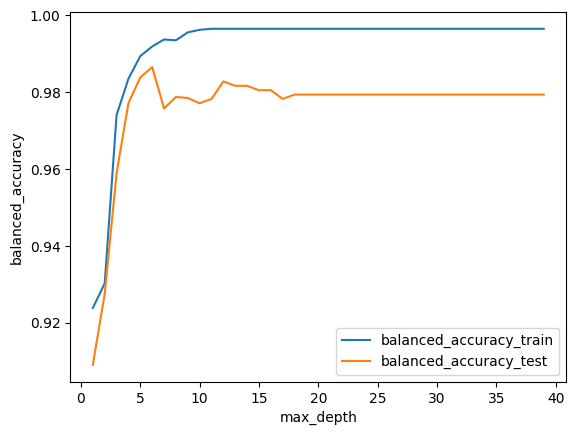

In [11]:
res = []
for n in range(1, 40):
    model = DecisionTreeClassifier(max_depth=n, min_samples_leaf=2, random_state=7)

    model.fit(feauters_train, target_train)
    pred_train = model.predict(feauters_train)
    pred_test = model.predict(feauters_val)

    res.append([n, balanced_accuracy_score(pred_train, target_train), balanced_accuracy_score(pred_test, target_val)])
    
res_pd = pd.DataFrame(res, columns=['max_depth', 'balanced_accuracy_train', 'balanced_accuracy_test'])

res_pd.set_index('max_depth')['balanced_accuracy_train'].plot(label='balanced_accuracy_train')
res_pd.set_index('max_depth')['balanced_accuracy_test'].plot(label='balanced_accuracy_test')
plt.legend()
plt.ylabel('balanced_accuracy')

In [12]:
res_pd[res_pd['balanced_accuracy_test'] == res_pd['balanced_accuracy_test'].max()]

,max_depth,balanced_accuracy_train,balanced_accuracy_test
5,6,0.991867,0.986512


Моя модель имеет лучший результат balanced_accuracy_test при max_depth = 6, до этого значения я вижу, что balanced_accuracy_train и balanced_accuracy_test начинают с очень маленьких значений и стремительно растут до значения max_depth = 6(скорее всего зона недообучения), после max_depth = 6 и до max_depth = 17 происходят колебания balanced_accuracy_test, в то время, как balanced_accuracy_train практически не меняется и очень близка к единице, далее обе метрики пракически не меняются и balanced_accuracy_test при этих значениях не самое лучшее(зона переобучения)

Text(0, 0.5, 'balanced_accuracy')

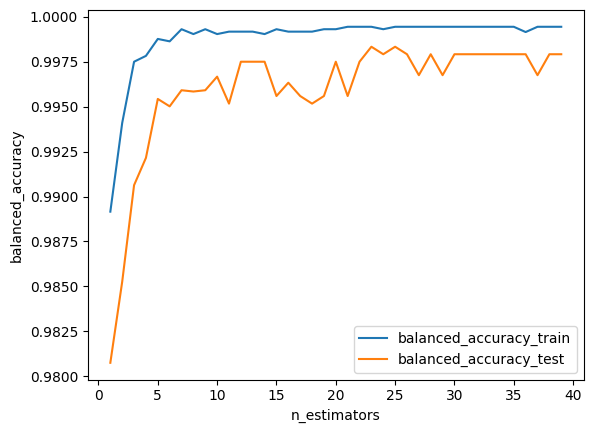

In [13]:
res = []
for param in range(1, 40, 1):
    model = RandomForestClassifier(n_estimators=param, random_state=7)

    model.fit(feauters_train, target_train)
    pred_train = model.predict(feauters_train)
    pred_test = model.predict(feauters_val)

    res.append([param, balanced_accuracy_score(pred_train, target_train), balanced_accuracy_score(pred_test, target_val)])
    
res_pd = pd.DataFrame(res, columns=['n_estimators', 'balanced_accuracy_train', 'balanced_accuracy_test'])

res_pd.set_index('n_estimators')['balanced_accuracy_train'].plot(label='balanced_accuracy_train')
res_pd.set_index('n_estimators')['balanced_accuracy_test'].plot(label='balanced_accuracy_test')
plt.legend()
plt.ylabel('balanced_accuracy')

In [14]:
res_pd[res_pd['balanced_accuracy_test'] == res_pd['balanced_accuracy_test'].max()]

,n_estimators,balanced_accuracy_train,balanced_accuracy_test
22,23,0.999436,0.998326
24,25,0.999436,0.998326


Сначала подбираю количество деревьев - __n_estimator__, чтобы потом при постоянном __n_estimator__, менять другие гиперпараметры, такие как __max_depth__ и __min_samples_leaf__
Выбираю __n_estimator__ = 25, как я думаю, на данном промежутке, а именно до 25 нет переобучения, оно происходит после 30, поэтому лучше выбрать большее количество деревьев

Text(0, 0.5, 'balanced_accuracy')

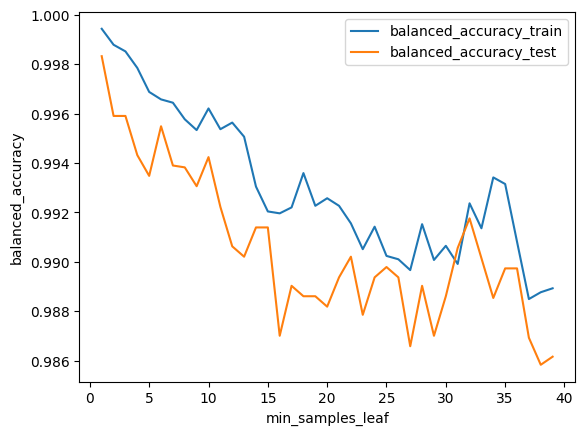

In [15]:
res = []
for param in range(1, 40, 1):
    model = RandomForestClassifier(n_estimators=25, min_samples_leaf=param, random_state=7)

    model.fit(feauters_train, target_train)
    pred_train = model.predict(feauters_train)
    pred_test = model.predict(feauters_val)

    res.append([param, balanced_accuracy_score(pred_train, target_train), balanced_accuracy_score(pred_test, target_val)])
    
res_pd = pd.DataFrame(res, columns=['min_samples_leaf', 'balanced_accuracy_train', 'balanced_accuracy_test'])

res_pd.set_index('min_samples_leaf')['balanced_accuracy_train'].plot(label='balanced_accuracy_train')
res_pd.set_index('min_samples_leaf')['balanced_accuracy_test'].plot(label='balanced_accuracy_test')
plt.legend()
plt.ylabel('balanced_accuracy')

In [16]:
res_pd[res_pd['balanced_accuracy_test'] == res_pd['balanced_accuracy_test'].max()]

,min_samples_leaf,balanced_accuracy_train,balanced_accuracy_test
0,1,0.999436,0.998326


Подобрал __min_samples_leaf__, он равен 1

Text(0, 0.5, 'balanced_accuracy')

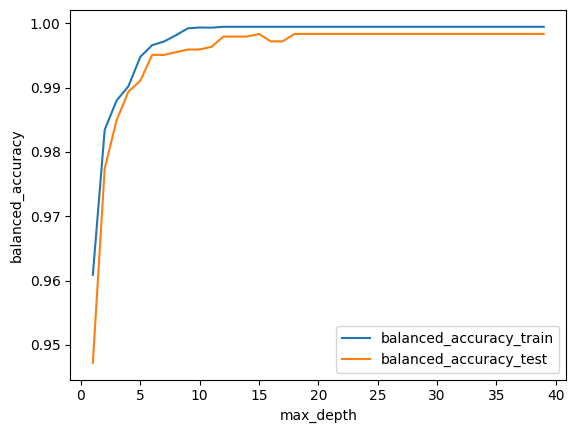

In [17]:
res = []
for param in range(1, 40, 1):
    model = RandomForestClassifier(n_estimators=25, max_depth=param, random_state=7)

    model.fit(feauters_train, target_train)
    pred_train = model.predict(feauters_train)
    pred_test = model.predict(feauters_val)

    res.append([param, balanced_accuracy_score(pred_train, target_train), balanced_accuracy_score(pred_test, target_val)])
    
res_pd = pd.DataFrame(res, columns=['max_depth', 'balanced_accuracy_train', 'balanced_accuracy_test'])

res_pd.set_index('max_depth')['balanced_accuracy_train'].plot(label='balanced_accuracy_train')
res_pd.set_index('max_depth')['balanced_accuracy_test'].plot(label='balanced_accuracy_test')
plt.legend()
plt.ylabel('balanced_accuracy')

In [18]:
res_pd[res_pd['balanced_accuracy_test'] == res_pd['balanced_accuracy_test'].max()]

,max_depth,balanced_accuracy_train,balanced_accuracy_test
14,15,0.999436,0.998326
17,18,0.999436,0.998326
18,19,0.999436,0.998326
19,20,0.999436,0.998326
20,21,0.999436,0.998326
21,22,0.999436,0.998326
22,23,0.999436,0.998326
23,24,0.999436,0.998326
24,25,0.999436,0.998326
25,26,0.999436,0.998326


На промежутке после 18 идёт переобучение, поэтому выбираем __max_depth__ равное 18

In [19]:
features_train_xgb, features_val_xgb, target_train_xgb, target_val_xgb = train_test_split(feauters_train, target_train, test_size=0.15, random_state=42)

[0]	validation_0-logloss:0.45775	validation_1-logloss:0.49753
[1]	validation_0-logloss:0.39725	validation_1-logloss:0.43157
[2]	validation_0-logloss:0.35019	validation_1-logloss:0.38197
[3]	validation_0-logloss:0.31180	validation_1-logloss:0.34184
[4]	validation_0-logloss:0.27934	validation_1-logloss:0.30732
[5]	validation_0-logloss:0.25125	validation_1-logloss:0.27701
[6]	validation_0-logloss:0.22805	validation_1-logloss:0.25340
[7]	validation_0-logloss:0.20665	validation_1-logloss:0.23035
[8]	validation_0-logloss:0.18815	validation_1-logloss:0.21063
[9]	validation_0-logloss:0.17195	validation_1-logloss:0.19307
[10]	validation_0-logloss:0.15781	validation_1-logloss:0.17747
[11]	validation_0-logloss:0.14494	validation_1-logloss:0.16383
[12]	validation_0-logloss:0.13319	validation_1-logloss:0.15182
[13]	validation_0-logloss:0.12349	validation_1-logloss:0.14186
[14]	validation_0-logloss:0.11402	validation_1-logloss:0.13229
[15]	validation_0-logloss:0.10581	validation_1-logloss:0.12328
[1

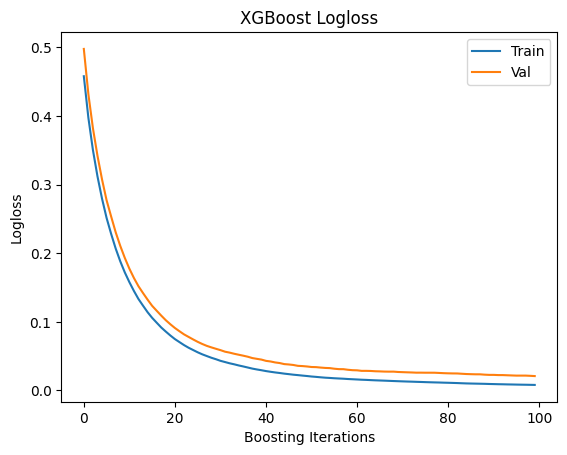

In [20]:
model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=42)

model.fit(features_train_xgb, target_train_xgb, eval_set=[(features_train_xgb, target_train_xgb), (features_val_xgb, target_val_xgb)])
pred_train = model.predict(feauters_train)
pred_test = model.predict(feauters_val)

print(f'BAS на обучающей выборке: {balanced_accuracy_score(pred_train, target_train)}')
print(f'BAS на валидационной выборке: {balanced_accuracy_score(pred_test, target_val)}')

epochs = len(model.evals_result()['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, model.evals_result()['validation_0']['logloss'], label='Train')
ax.plot(x_axis, model.evals_result()['validation_1']['logloss'], label='Val')
ax.legend()

plt.ylabel('Logloss')
plt.xlabel('Boosting Iterations')
plt.title('XGBoost Logloss')
plt.show()

Здесь функция потерь __logloss__ быстро уменьшается от 0.5 до практически 0 что на валидационных что на тренировочных данных, переобучение, как мне кажется, начинается после 60 итераций, там обе прямые более менее выпрямляются

Теперь изменим __learning_rate__ и __max_depth__ и посмотрим, как меняется функция потерь

[0]	validation_0-logloss:0.53370	validation_1-logloss:0.58125
[1]	validation_0-logloss:0.52479	validation_1-logloss:0.57158
[2]	validation_0-logloss:0.51618	validation_1-logloss:0.56221
[3]	validation_0-logloss:0.50784	validation_1-logloss:0.55319
[4]	validation_0-logloss:0.49976	validation_1-logloss:0.54446
[5]	validation_0-logloss:0.49191	validation_1-logloss:0.53591
[6]	validation_0-logloss:0.48429	validation_1-logloss:0.52762
[7]	validation_0-logloss:0.47692	validation_1-logloss:0.51969
[8]	validation_0-logloss:0.46975	validation_1-logloss:0.51197
[9]	validation_0-logloss:0.46278	validation_1-logloss:0.50448
[10]	validation_0-logloss:0.45600	validation_1-logloss:0.49722
[11]	validation_0-logloss:0.44939	validation_1-logloss:0.49011
[12]	validation_0-logloss:0.44295	validation_1-logloss:0.48322
[13]	validation_0-logloss:0.43667	validation_1-logloss:0.47648
[14]	validation_0-logloss:0.43054	validation_1-logloss:0.46996
[15]	validation_0-logloss:0.42456	validation_1-logloss:0.46358
[1

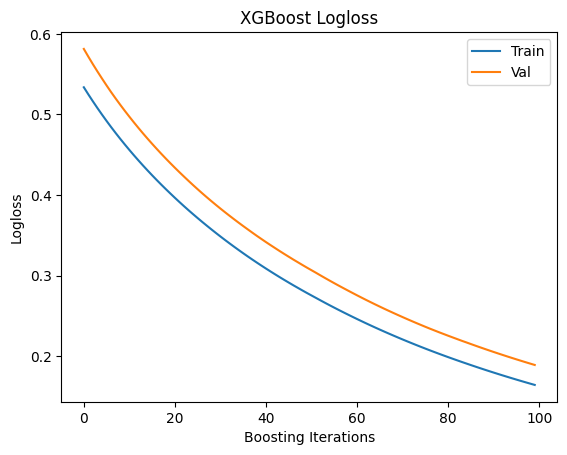

In [21]:
model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.01, eval_metric='logloss', random_state=42)

model.fit(features_train_xgb, target_train_xgb, eval_set=[(features_train_xgb, target_train_xgb), (features_val_xgb, target_val_xgb)])
pred_train = model.predict(feauters_train)
pred_test = model.predict(feauters_val)

print(f'BAS на обучающей выборке: {balanced_accuracy_score(pred_train, target_train)}')
print(f'BAS на валидационной выборке: {balanced_accuracy_score(pred_test, target_val)}')

epochs = len(model.evals_result()['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, model.evals_result()['validation_0']['logloss'], label='Train')
ax.plot(x_axis, model.evals_result()['validation_1']['logloss'], label='Val')
ax.legend()

plt.ylabel('Logloss')
plt.xlabel('Boosting Iterations')
plt.title('XGBoost Logloss')
plt.show()

Функция потерь убывает плавно, но не достигает своего минимума, как в первом случае

[0]	validation_0-logloss:0.50238	validation_1-logloss:0.54600
[1]	validation_0-logloss:0.46817	validation_1-logloss:0.50815
[2]	validation_0-logloss:0.43861	validation_1-logloss:0.47560
[3]	validation_0-logloss:0.41247	validation_1-logloss:0.44747
[4]	validation_0-logloss:0.38929	validation_1-logloss:0.42243
[5]	validation_0-logloss:0.36844	validation_1-logloss:0.40019
[6]	validation_0-logloss:0.34960	validation_1-logloss:0.37989
[7]	validation_0-logloss:0.33242	validation_1-logloss:0.36169
[8]	validation_0-logloss:0.31543	validation_1-logloss:0.34278
[9]	validation_0-logloss:0.30081	validation_1-logloss:0.32694
[10]	validation_0-logloss:0.28712	validation_1-logloss:0.31260
[11]	validation_0-logloss:0.27366	validation_1-logloss:0.29766
[12]	validation_0-logloss:0.26213	validation_1-logloss:0.28528
[13]	validation_0-logloss:0.25140	validation_1-logloss:0.27459
[14]	validation_0-logloss:0.24044	validation_1-logloss:0.26230
[15]	validation_0-logloss:0.23113	validation_1-logloss:0.25222
[1

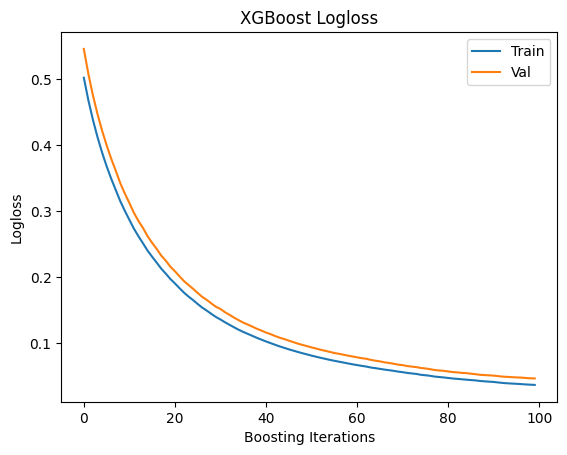

In [22]:
model = XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.05, eval_metric='logloss', random_state=42)

model.fit(features_train_xgb, target_train_xgb, eval_set=[(features_train_xgb, target_train_xgb), (features_val_xgb, target_val_xgb)])
pred_train = model.predict(feauters_train)
pred_test = model.predict(feauters_val)

print(f'BAS на обучающей выборке: {balanced_accuracy_score(pred_train, target_train)}')
print(f'BAS на валидационной выборке: {balanced_accuracy_score(pred_test, target_val)}')

epochs = len(model.evals_result()['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, model.evals_result()['validation_0']['logloss'], label='Train')
ax.plot(x_axis, model.evals_result()['validation_1']['logloss'], label='Val')
ax.legend()

plt.ylabel('Logloss')
plt.xlabel('Boosting Iterations')
plt.title('XGBoost Logloss')
plt.show()

Ситуация, практически как в первом случае, только в этом, чтобы достичь минимума функции потерь, как мне кажется, нужно проделать более 100 итераций, в то время, как в первом случае, этот минимум был достигнут примерно за 60 итераций

Далее увеличим количество деревьев с 100 до 1000 и посмотрим, что будет

[0]	validation_0-logloss:0.45775	validation_1-logloss:0.49753
[1]	validation_0-logloss:0.39725	validation_1-logloss:0.43157
[2]	validation_0-logloss:0.35019	validation_1-logloss:0.38197
[3]	validation_0-logloss:0.31180	validation_1-logloss:0.34184
[4]	validation_0-logloss:0.27934	validation_1-logloss:0.30732
[5]	validation_0-logloss:0.25125	validation_1-logloss:0.27701
[6]	validation_0-logloss:0.22805	validation_1-logloss:0.25340
[7]	validation_0-logloss:0.20665	validation_1-logloss:0.23035
[8]	validation_0-logloss:0.18815	validation_1-logloss:0.21063
[9]	validation_0-logloss:0.17195	validation_1-logloss:0.19307
[10]	validation_0-logloss:0.15781	validation_1-logloss:0.17747
[11]	validation_0-logloss:0.14494	validation_1-logloss:0.16383
[12]	validation_0-logloss:0.13319	validation_1-logloss:0.15182
[13]	validation_0-logloss:0.12349	validation_1-logloss:0.14186
[14]	validation_0-logloss:0.11402	validation_1-logloss:0.13229
[15]	validation_0-logloss:0.10581	validation_1-logloss:0.12328
[1

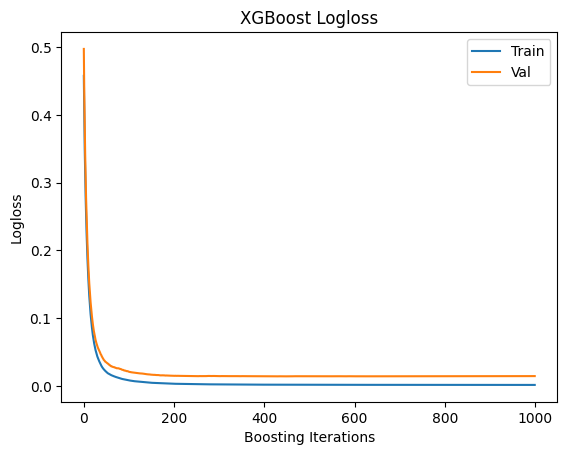

In [27]:
model = XGBClassifier(n_estimators=1000, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=42)

model.fit(features_train_xgb, target_train_xgb, eval_set=[(features_train_xgb, target_train_xgb), (features_val_xgb, target_val_xgb)])
pred_train = model.predict(feauters_train)
pred_test = model.predict(feauters_val)

print(f'BAS на обучающей выборке: {balanced_accuracy_score(pred_train, target_train)}')
print(f'BAS на валидационной выборке: {balanced_accuracy_score(pred_test, target_val)}')

epochs = len(model.evals_result()['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, model.evals_result()['validation_0']['logloss'], label='Train')
ax.plot(x_axis, model.evals_result()['validation_1']['logloss'], label='Val')
ax.legend()

plt.ylabel('Logloss')
plt.xlabel('Boosting Iterations')
plt.title('XGBoost Logloss')
plt.show()

Модель минимизировала свою функцию потерь уже примерно за 100 итераций, и остальные 900 значени функции потерь не менялось, получается, что модель сделала лишние 900 итераций

Далее я должен был изучить гиперпараметр __early_stoppin_rounds__

[0]	validation_0-logloss:0.45775	validation_1-logloss:0.49753
[1]	validation_0-logloss:0.39725	validation_1-logloss:0.43157
[2]	validation_0-logloss:0.35019	validation_1-logloss:0.38197
[3]	validation_0-logloss:0.31180	validation_1-logloss:0.34184
[4]	validation_0-logloss:0.27934	validation_1-logloss:0.30732
[5]	validation_0-logloss:0.25125	validation_1-logloss:0.27701
[6]	validation_0-logloss:0.22805	validation_1-logloss:0.25340
[7]	validation_0-logloss:0.20665	validation_1-logloss:0.23035
[8]	validation_0-logloss:0.18815	validation_1-logloss:0.21063
[9]	validation_0-logloss:0.17195	validation_1-logloss:0.19307
[10]	validation_0-logloss:0.15781	validation_1-logloss:0.17747
[11]	validation_0-logloss:0.14494	validation_1-logloss:0.16383
[12]	validation_0-logloss:0.13319	validation_1-logloss:0.15182
[13]	validation_0-logloss:0.12349	validation_1-logloss:0.14186
[14]	validation_0-logloss:0.11402	validation_1-logloss:0.13229
[15]	validation_0-logloss:0.10581	validation_1-logloss:0.12328
[1

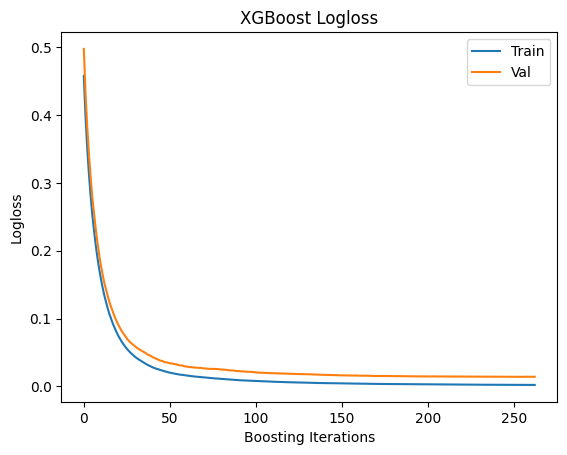

In [28]:
model = XGBClassifier(n_estimators=1000, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=42, early_stopping_rounds=10)

model.fit(features_train_xgb, target_train_xgb, eval_set=[(features_train_xgb, target_train_xgb), (features_val_xgb, target_val_xgb)])
pred_train = model.predict(feauters_train)
pred_test = model.predict(feauters_val)

print(f'BAS на обучающей выборке: {balanced_accuracy_score(pred_train, target_train)}')
print(f'BAS на валидационной выборке: {balanced_accuracy_score(pred_test, target_val)}')

epochs = len(model.evals_result()['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, model.evals_result()['validation_0']['logloss'], label='Train')
ax.plot(x_axis, model.evals_result()['validation_1']['logloss'], label='Val')
ax.legend()

plt.ylabel('Logloss')
plt.xlabel('Boosting Iterations')
plt.title('XGBoost Logloss')
plt.show()

Как я вижу, изначально было указано, что деревьев 1000, результат практически перестал улучшаться после 150 и произошла досрочная остановка на значении 261

__Вывод__:

Сравнивая все модели, __RandomForestClassifier__ показал самый высокий результат на валидационной выборке по метрике balanced_accuracy_score = 0.998326